## Do it! Natural Language Processing using BERT and GPT - part4
#### 한국어 자연어 처리에 관한 내용을 정리하였습니다. Do it! BERT와 GPT로 배우는 자연어 처리(이기창 지음)을 참고하였습니다.
## 4. 문서에 꼬리표 달기
### 4.1 문서 분류 모델 훑어보기
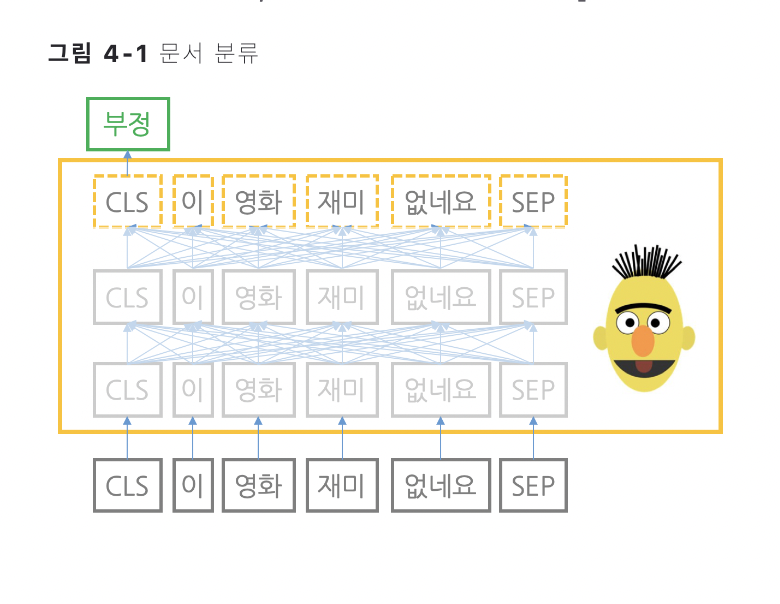
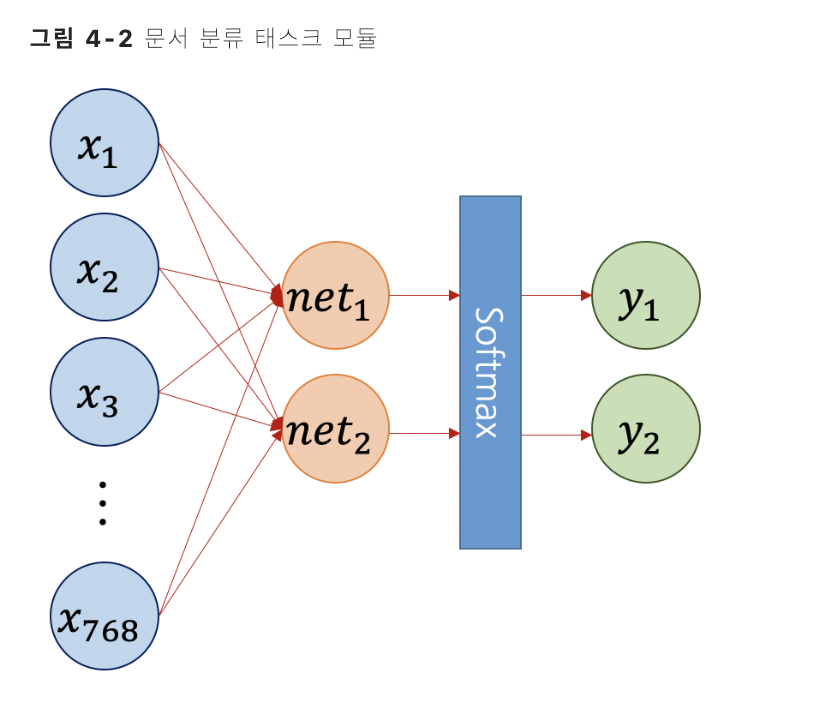

### 4.2 문서 분류 모델 학습하기

In [5]:
#### 모델 환경 설정
import torch
from ratsnlp.nlpbook.classification import ClassificationTrainArguments
args = ClassificationTrainArguments(
    pretrained_model_name = 'beomi/kcbert-base',
    downstream_corpus_root_dir='./part4-corpus',
    downstream_corpus_name='nsmc',
    downstream_model_dir='./part4-model',
    batch_size=32 if torch.cuda.is_available() else 4,
    learning_rate=5e-5,
    max_seq_length=128,
    epochs = 3, 
    seed = 7
)

#### 랜덤 시드 고정
from ratsnlp import nlpbook
nlpbook.set_seed(args)

#### 로거 설정
nlpbook.set_logger(args)

#### 말뭉치 내려 받기
from Korpora import Korpora
Korpora.fetch(corpus_name = args.downstream_corpus_name, root_dir=args.downstream_corpus_root_dir, force_download=True,)

set seed: 7


[nsmc] download ratings_train.txt: 14.6MB [00:02, 7.29MB/s]                            
[nsmc] download ratings_test.txt: 4.90MB [00:00, 5.37MB/s]                            


In [6]:
#### 토크나이저 준비하기
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(args.pretrained_model_name, do_lower_case = False)

#### 학습 데이터셋 구축
from ratsnlp.nlpbook.classification import NsmcCorpus, ClassificationDataset
corpus = NsmcCorpus()
train_dataset = ClassificationDataset(args = args, corpus=corpus, tokenizer=tokenizer, mode = 'train')

In [10]:
print(train_dataset[0])

ClassificationFeatures(input_ids=[2, 2170, 832, 5045, 17, 17, 7992, 29734, 4040, 10720, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [12]:
#### 학습 데이터 로더 구축
from torch.utils.data import DataLoader, RandomSampler
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, sampler=RandomSampler(train_dataset, replacement=False),
                             collate_fn=nlpbook.data_collator, drop_last=False, num_workers=args.cpu_workers)

#### 평가용 데이터 로더 구착
from torch.utils.data import SequentialSampler
val_dataset = ClassificationDataset(args=args, corpus=corpus, tokenizer = tokenizer, mode='test')
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, sampler=SequentialSampler(val_dataset), collate_fn=nlpbook.data_collator,
                           drop_last=False, num_workers=args.cpu_workers)

In [13]:
#### 모델 초기화
from transformers import BertConfig, BertForSequenceClassification
pretrained_model_config = BertConfig.from_pretrained(args.pretrained_model_name, num_labels=corpus.num_labels,)
model = BertForSequenceClassification.from_pretrained(args.pretrained_model_name, config = pretrained_model_config,)

#### Task 정의
from ratsnlp.nlpbook.classification import ClassificationTask
task = ClassificationTask(model, args)

#### 트레이너 정의
trainer = nlpbook.get_trainer(args)

#### 학습 개시
trainer.fit(task, train_dataloader = train_dataloader, val_dataloaders=val_dataloader)

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

TypeError: fit() got an unexpected keyword argument 'train_dataloader'

### 4.3 학습 마친 모델을 실전 투입하기

In [ ]:
#### 인퍼런스 설정
from ratsnlp.nlpbook.classification import ClassificationDeployArguments
args = ClassificationDeployArguments(pretrained_model_name = 'beomi/kcbert-base', downstream_model_dir = './part4-model',
                                    max_seq_length = 128,)

#### 토크나이저 로드
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(args.pretrained_model_name, do_lower_case = False,)

#### 체크포인트 로드
import torch
fine_tuned_model_ckpt = torch.load(args.downstream_model_checkpoint_fpath, map_location=torch.device('cpu',))

#### BERT 설정 로드
from transformers import BertConfig
pretrained_model_config = BertConfig.from_pretrained(args.pretrained_model_name, 
                                                     num_labes = fine_tuned_model_ckpt['state_dict']['model.classifier.bias'].shape.numel(),)

#### BERT 모델 초기화
from transformers import BertForSequenceClassification
model = BertForSequenceClassification(pretrained_model_config)

#### 체크포인트 주입하기
model.load_state_dict({k.replace("model.", ""):v for k, v in fine_tuned_model_ckpt['state_dict'].items()})

#### 평가모드로 전환
model.eval()

#### 인퍼런스 함수 
def inference_fn(sentence):
    inputs = tokenizer([sentence], max_length = args.max_seq_length, padding = 'max_length', truncation = True)
    
    with torch.no_grad():
        outputs = model(**{k:torch.tensor(v) for k, v in inputs.items()})
        prob = outputs.logits.softmax(dim=1)
        positive_prob = round(prob[0][1].item(), 4)
        negative_prob = round(prob[0][0].item(), 4)
        pred = '긍정 (positive)' if torch.argmax(prob) == 1 else "부정 (negative)"
    
    return {
        'sentence' : sentence,
        'prediction' : pred, 
        'positive_data' : f"긍정 {positivie_prob}",
        'negative_data' : f"부정 {negative_prob}",
        'positive_width' : f'{positive_prob * 100}%',
        'negative_widht' : f'{negative_prob * 100}%',
    }

#### 웹 서비스 시작하기(flask 기반)
from ratsnlp.nlpbook.classification import get_web_service_app
app = get_web_service_app(inference_fn)
app.run()